In [1]:
from utils import import_train_data
df, test_df = import_train_data()
df.sample(10)

,image_path,category,target,r
2518,../data/알파벳인식/O/r_O/4d_al_r_O_48.jpg,alphabet,O,True
1377,../data/알파벳인식/D/r_D/4d_al_r_D_27.jpg,alphabet,D,True
1269,../data/알파벳인식/C/r_C/4d_al_r_c_19.jpg,alphabet,C,True
489,../data/숫자인식/04/r_n04/4d_r_n04_40.jpg,number,4,True
2212,../data/알파벳인식/L/r_L/4d_al_r_L_42.jpg,alphabet,L,True
137,../data/숫자인식/01/n01/4d_n01_38.jpg,number,1,False
630,../data/숫자인식/06/n06/4d_n06_31.jpg,number,6,False
2791,../data/알파벳인식/R/r_R/4d_al_r_R_21.jpg,alphabet,R,True
1189,../data/알파벳인식/B/r_B/4d_al_r_b_39.jpg,alphabet,B,True
3250,../data/알파벳인식/W/W/4d_al_W_30.jpg,alphabet,W,False


# feature engineering

In [2]:
import cv2
import numpy as np

def sort_vertices(vertices, h, w):
    image_corners = np.array([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]], dtype=np.float32)
    corner_candidates = []
    for i in range(4):
        corner_candidates.append(np.roll(vertices, i, axis=0))

    displacements = []
    for corners in corner_candidates:
        corners = np.array(corners, dtype=np.float32)
        displacement = 0
        for corner, image_corner in zip(corners, image_corners):
            displacement += np.linalg.norm(corner - image_corner)
        displacements.append(displacement)

    min_displacement_index = np.argmin(displacements)

    best_corners = corner_candidates[min_displacement_index]

    return np.array(best_corners, dtype=np.float32)

def get_board_corners(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    contour_areas = [cv2.contourArea(contour) for contour in contours]
    largest_contour_indices = np.argsort(contour_areas)[-3:]
    largest_contours = [contours[i] for i in largest_contour_indices]

    largest_contours.sort(key=cv2.contourArea, reverse=True)

    for contour in largest_contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.05 * perimeter, True)
        approx = approx[:, 0, :]
        if len(approx) == 4:
            return approx

    return np.array([[0, 0], [0, img.shape[0]-1], [img.shape[1]-1, img.shape[0]-1], [img.shape[1]-1, 0]], dtype=np.float32)

def warp_image(img, origin_points, h, w):
    dest_points = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]])
    perspective_matrix = cv2.getPerspectiveTransform(origin_points, dest_points)
    transformed = cv2.warpPerspective(img, perspective_matrix, (w, h), flags=cv2.INTER_LINEAR)
    return transformed

def warp_to_board(img):
    corners = get_board_corners(img)
    h, w, _ = img.shape
    origin_points = sort_vertices(corners, h, w)
    img = warp_image(img, origin_points, h, w)
    return img

def get_masks(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image = cv2.GaussianBlur(image, (5, 5), 0)

    image_s = image[:, :, 1]
    thresh_s, orange = cv2.threshold(image_s, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if thresh_s < 50: orange = np.zeros_like(orange)

    image_v = image[:, :, 2]
    thresh_v, gray = cv2.threshold(image_v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    gray = np.where(image_v <= thresh_v*0.8, 255, 0).astype(np.uint8)
    if thresh_v > 225: gray = np.zeros_like(gray)

    border = np.zeros_like(gray)
    border[10:-10, 10:-10] = 255

    gray = cv2.bitwise_and(gray, gray, mask=border)
    gray = cv2.bitwise_and(gray, gray, mask=cv2.bitwise_not(orange))
    gray = cv2.dilate(gray, (3, 3), iterations=3)
    gray = cv2.erode(gray, (3, 3), iterations=3)
    
    orange = cv2.bitwise_and(orange, orange, mask=border)

    return orange, gray
    
    
def mask_square(mask):
    # crop to non-zero region of mask using findNonZero
    pts = cv2.findNonZero(mask)
    x, y, w, h = cv2.boundingRect(pts)
    mask = mask[y:y+h, x:x+w]

    # and pad to square shape
    if mask.shape[0] > mask.shape[1]:
        pad = (mask.shape[0] - mask.shape[1]) // 2
        mask = np.pad(mask, ((0, 0), (pad, pad)), constant_values=0)
    elif mask.shape[1] > mask.shape[0]:
        pad = (mask.shape[1] - mask.shape[0]) // 2
        mask = np.pad(mask, ((pad, pad), (0, 0)), constant_values=0)

    return mask

def get_mask_area(mask):
    total_area = mask.shape[0]*mask.shape[1]
    mask_area_proportional = np.count_nonzero(mask) / total_area
    return mask_area_proportional

def preprocess(image, img_size=(28, 28), r=False):
    if isinstance(image, str):
        image = cv2.imread(image)

    image = warp_to_board(image)
    image = cv2.resize(image, (224, 224))

    orange, gray = get_masks(image)

    if r: 
        orange, gray = gray, orange

    main_area = get_mask_area(orange)
    gray_area = get_mask_area(gray)

    image = orange

    if np.count_nonzero(image) == 0:
        return np.zeros((28, 28)), 0, 0

    image = mask_square(image)
    image = cv2.resize(image, img_size)
    image = cv2.erode(image, (3, 3), iterations=1)
    image = cv2.dilate(image, (3, 3), iterations=1)
    _, image = cv2.threshold(image, 128, 1, cv2.THRESH_BINARY)
    return image, main_area, gray_area


In [ ]:
df[['image', 'main_area', 'gray_area']] = df.apply(lambda row: preprocess(row['image_path'], r=row['r']), axis=1, result_type='expand')

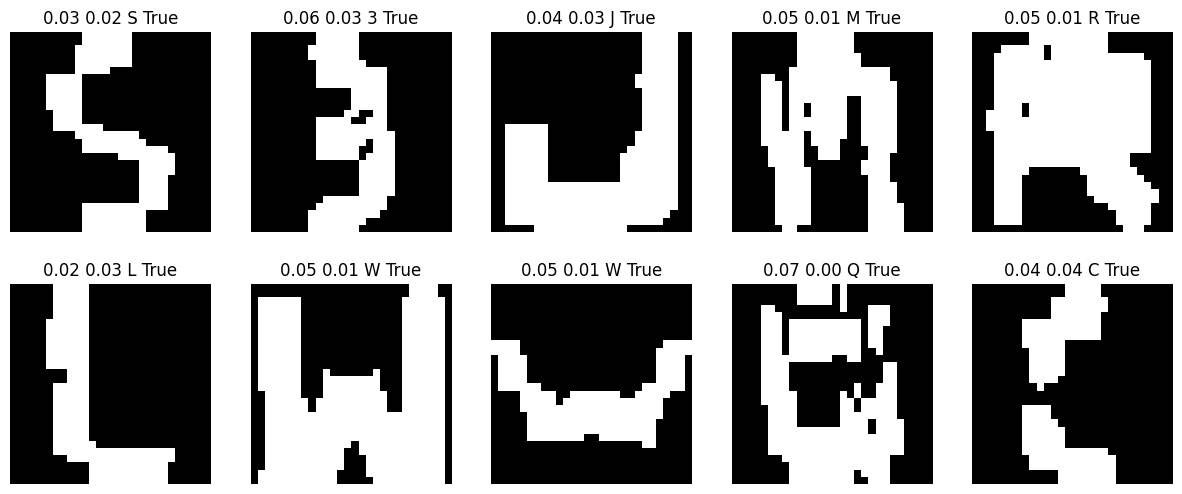

In [299]:
# check some images to make sure it worked
import matplotlib.pyplot as plt

random_sample = df[df['r']==True].sample(10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(random_sample.iloc[i]['image'], cmap='gray')
    ax.set_title(f'{random_sample.iloc[i]["main_area"]:.2f} {random_sample.iloc[i]["gray_area"]:.2f} {random_sample.iloc[i]["target"]} {random_sample.iloc[i]["r"]}')
    ax.axis('off')

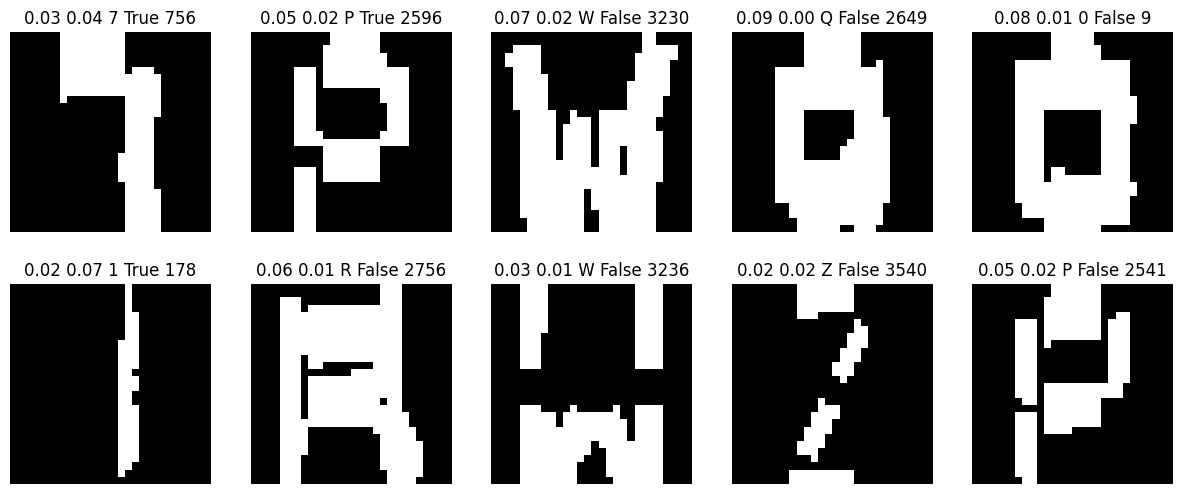

In [355]:
import random
# get 10 random samples and plot them with their index
random_sample = random.sample(range(len(df)), 10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(df.iloc[random_sample[i]]['image'], cmap='gray')
    ax.set_title(f'{df.iloc[random_sample[i]]["main_area"]:.2f} {df.iloc[random_sample[i]]["gray_area"]:.2f} {df.iloc[random_sample[i]]["target"]} {df.iloc[random_sample[i]]["r"]} {random_sample[i]}')
    ax.axis('off')

In [363]:
test_df[['image', 'main_area', 'gray_area']] = test_df.apply(lambda row: preprocess(row['image_path'], r=row['r']), axis=1, result_type='expand')
test_df.sample(10)

,image_path,category,target,r,image,main_area,gray_area
664,../data/알파벳인식/알파벳 추가/test_D/te_D_14.jpg,alphabet,D,False,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",0.067761,0.010702
844,../data/알파벳인식/알파벳 추가/test_G/te_r_G_20.jpg,alphabet,G,True,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",0.039023,0.006178
78,../data/숫자인식/숫자 추가/test_1/te_r_1_04.jpg,number,1,True,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",0.024235,0.072943
913,../data/알파벳인식/알파벳 추가/test_I/te_I_13.jpg,alphabet,I,False,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.020069,0.051339
105,../data/숫자인식/숫자 추가/test_2/te_2_05.jpg,number,2,False,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",0.040378,0.017738
1073,../data/알파벳인식/알파벳 추가/test_L/te_L_24.jpg,alphabet,L,False,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0.000000
938,../data/알파벳인식/알파벳 추가/test_I/te_r_I_14.jpg,alphabet,I,True,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",0.019511,0.068698
1912,../data/자유패턴/40/40_g/40_g16.jpg,free_pattern,free,None,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0.000000
65,../data/숫자인식/숫자 추가/test_1/te_1_15.jpg,number,1,False,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",0.011400,0.029237
822,../data/알파벳인식/알파벳 추가/test_G/te_G_23.jpg,alphabet,G,False,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,...",0.070532,0.009148


In [ ]:
from sklearn.model_selection import train_test_split

X_test = test_df[['image', 'main_area', 'gray_area']]
y_test = test_df[['category', 'target', 'r']]

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=42)
X_val.shape, X_test.shape, y_val.shape, y_test.shape

In [366]:
X_train = df[['image', 'main_area', 'gray_area']]
y_train = df[['category', 'target', 'r']]
X_train.shape, y_train.shape

((3971, 3), (3971, 3))

# import pretrained resnet and check its mnist acc

In [357]:
from tensorflow.keras import models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from keras.utils import get_file

# load the MNIST dataset test images and labels
(_, _), (test_images, test_labels) = mnist.load_data()

# normalize the images
test_images = test_images.astype('float32') / 255
# create one-hot labels
test_labels_onehot = to_categorical(test_labels)

# download the model
model_path = get_file('../models/resnet_mnist_digits.hdf5', 'https://huggingface.co/lane99/resnet_mnist_digits/resolve/main/resnet_mnist_digits.hdf5')
# import the model
resnet = models.load_model(model_path)

resnet.summary()

331168352/331168352 [==============================] - 33s 0us/step


2023-09-07 18:17:35.293351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-07 18:17:35.552539: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 batch_normalization_294 (B  (None, 28, 28, 1)            4         ['input_12[0][0]']            
 atchNormalization)                                                                               
                                                                                                  
 conv2d_328 (Conv2D)         (None, 28, 28, 128)          1280      ['batch_normalization_294[0][0
                                                                    ]']                           
                                                                                           

In [358]:
# evaluate the model
evaluation_conv = resnet.evaluate(test_images, test_labels_onehot)
print("Accuracy: ", str(evaluation_conv[1]))

313/313 [==============================] - 179s 570ms/step - loss: 0.0244 - accuracy: 0.9945
Accuracy:  0.9944999814033508


In [361]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation

for layer in resnet.layers:
    layer.trainable = False

base_model = Model(inputs=resnet.input, outputs=resnet.layers[-2].output)

base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 batch_normalization_294 (B  (None, 28, 28, 1)            4         ['input_12[0][0]']            
 atchNormalization)                                                                               
                                                                                                  
 conv2d_328 (Conv2D)         (None, 28, 28, 128)          1280      ['batch_normalization_294[0][0
                                                                    ]']                           
                                                                                              

In [362]:
model = Sequential([
    base_model,
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(37, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [368]:
classes = [str(i) for i in range(10)] + [chr(i) for i in range(ord('A'), ord('Z') + 1)] + ['free']

X_train_img = np.array(X_train['image'].tolist())

y_train_t = y_train['target']
y_train_t = pd.get_dummies(y_train_t)
y_train_t = y_train_t[classes]

X_train_img.shape, y_train_t.shape

((3971, 28, 28), (3971, 37))

In [369]:
X_val_img = np.array(X_val['image'].tolist())

y_val_t = y_val['target']
y_val_t = pd.get_dummies(y_val_t)
y_val_t = y_val_t[classes]

X_val_img.shape, y_val_t.shape

((1577, 28, 28), (1577, 37))

In [370]:
history = model.fit(X_train_img, y_train_t, epochs=30, batch_size=32, validation_data=(X_val_img, y_val_t))

Epoch 1/30
125/125 [==============================] - 103s 807ms/step - loss: 3.3161 - accuracy: 0.1012 - val_loss: 2.6997 - val_accuracy: 0.3164
Epoch 2/30
125/125 [==============================] - 100s 800ms/step - loss: 2.7057 - accuracy: 0.2317 - val_loss: 2.0914 - val_accuracy: 0.4084
Epoch 3/30
125/125 [==============================] - 100s 800ms/step - loss: 2.3929 - accuracy: 0.2856 - val_loss: 1.8295 - val_accuracy: 0.5200
Epoch 4/30
125/125 [==============================] - 105s 842ms/step - loss: 2.1446 - accuracy: 0.3485 - val_loss: 1.6145 - val_accuracy: 0.5523
Epoch 5/30
125/125 [==============================] - 105s 843ms/step - loss: 2.0088 - accuracy: 0.3697 - val_loss: 1.4841 - val_accuracy: 0.5897
Epoch 6/30
125/125 [==============================] - 105s 844ms/step - loss: 1.8598 - accuracy: 0.4014 - val_loss: 1.3993 - val_accuracy: 0.6107
Epoch 7/30
125/125 [==============================] - 104s 830ms/step - loss: 1.7510 - accuracy: 0.4344 - val_loss: 1.2598 -

In [379]:
model.save('../models/resnet.hdf5')

/home/user/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [378]:
model.fit(X_train_img, y_train_t, epochs=20, batch_size=32, validation_data=(X_val_img, y_val_t))

Epoch 1/20
125/125 [==============================] - 95s 758ms/step - loss: 0.8024 - accuracy: 0.7109 - val_loss: 0.7223 - val_accuracy: 0.7603
Epoch 2/20
125/125 [==============================] - 97s 780ms/step - loss: 0.7944 - accuracy: 0.7086 - val_loss: 0.7267 - val_accuracy: 0.7590
Epoch 3/20
125/125 [==============================] - 98s 782ms/step - loss: 0.7663 - accuracy: 0.7142 - val_loss: 0.6980 - val_accuracy: 0.7762
Epoch 4/20
125/125 [==============================] - 97s 781ms/step - loss: 0.7627 - accuracy: 0.7096 - val_loss: 0.7241 - val_accuracy: 0.7781
Epoch 5/20
125/125 [==============================] - 97s 781ms/step - loss: 0.7524 - accuracy: 0.7207 - val_loss: 0.7154 - val_accuracy: 0.7876
Epoch 6/20
125/125 [==============================] - 97s 781ms/step - loss: 0.8294 - accuracy: 0.7117 - val_loss: 0.7060 - val_accuracy: 0.7698
Epoch 7/20
125/125 [==============================] - 97s 779ms/step - loss: 0.7698 - accuracy: 0.7124 - val_loss: 0.7082 - val_ac

In [380]:
model = Sequential([
    base_model,
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(37, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_img, y_train_t, epochs=30, batch_size=32, validation_data=(X_val_img, y_val_t))

Epoch 1/30
125/125 [==============================] - 104s 817ms/step - loss: 2.7807 - accuracy: 0.2312 - val_loss: 1.9123 - val_accuracy: 0.4724
Epoch 2/30
125/125 [==============================] - 104s 833ms/step - loss: 1.8634 - accuracy: 0.4284 - val_loss: 1.4629 - val_accuracy: 0.5669
Epoch 3/30
125/125 [==============================] - 109s 876ms/step - loss: 1.5564 - accuracy: 0.5064 - val_loss: 1.2818 - val_accuracy: 0.6303
Epoch 4/30
125/125 [==============================] - 106s 853ms/step - loss: 1.3209 - accuracy: 0.5737 - val_loss: 1.1260 - val_accuracy: 0.6557
Epoch 5/30
125/125 [==============================] - 102s 819ms/step - loss: 1.1515 - accuracy: 0.6240 - val_loss: 0.9759 - val_accuracy: 0.6944
Epoch 6/30
125/125 [==============================] - 102s 816ms/step - loss: 1.0585 - accuracy: 0.6482 - val_loss: 0.9586 - val_accuracy: 0.7064
Epoch 7/30
125/125 [==============================] - 102s 815ms/step - loss: 0.9677 - accuracy: 0.6651 - val_loss: 0.8939 -

In [381]:
model.save('../models/resnet_2.hdf5')

/home/user/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [383]:
model = Sequential([
    base_model,
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(37, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_img, y_train_t, epochs=30, batch_size=32, validation_data=(X_val_img, y_val_t))

Epoch 1/30
125/125 [==============================] - 103s 816ms/step - loss: 2.1423 - accuracy: 0.3971 - val_loss: 1.4790 - val_accuracy: 0.5606
Epoch 2/30
125/125 [==============================] - 104s 833ms/step - loss: 1.3242 - accuracy: 0.6024 - val_loss: 1.1849 - val_accuracy: 0.6468
Epoch 3/30
125/125 [==============================] - 105s 843ms/step - loss: 1.0840 - accuracy: 0.6610 - val_loss: 1.0400 - val_accuracy: 0.6747
Epoch 4/30
125/125 [==============================] - 106s 849ms/step - loss: 0.9195 - accuracy: 0.7069 - val_loss: 0.9635 - val_accuracy: 0.6956
Epoch 5/30
125/125 [==============================] - 105s 846ms/step - loss: 0.7900 - accuracy: 0.7363 - val_loss: 0.8653 - val_accuracy: 0.7286
Epoch 6/30
125/125 [==============================] - 104s 833ms/step - loss: 0.7248 - accuracy: 0.7613 - val_loss: 0.8301 - val_accuracy: 0.7438
Epoch 7/30
125/125 [==============================] - 105s 840ms/step - loss: 0.6680 - accuracy: 0.7791 - val_loss: 0.7795 -